In [60]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/14/03/3c854ca3e02eedf614abba4b2e177c469bf3af58207fa30d5098c5d652fe/yfinance-0.2.37-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 5.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for html5lib>=1.1 from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a4951

In [19]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [35]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import tensorflow as tf
import numpy as np
from pathlib import Path
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

In [6]:
# Define the stock symbols for the financial institutions we're interested in
stock_symbols = ['AAPL', 'KO', 'NKE', 'EA']
# Define the start and end dates for our data
start_date = '2020-01-01'
end_date = '2024-02-28'

# Function to download stock data
def download_stock_data(symbols):
    data = {}
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start=start_date, end=end_date)
    return data

# Download stock data
stocks_data = download_stock_data(stock_symbols)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
# Display the first few rows of JPMorgan's stock data
print(stocks_data['AAPL'].tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-02-21  181.940002  182.889999  180.660004  182.320007  182.320007   
2024-02-22  183.479996  184.960007  182.460007  184.369995  184.369995   
2024-02-23  185.009995  185.039993  182.229996  182.520004  182.520004   
2024-02-26  182.240005  182.759995  180.649994  181.160004  181.160004   
2024-02-27  181.100006  183.919998  179.559998  182.630005  182.630005   

              Volume  
Date                  
2024-02-21  41529700  
2024-02-22  52292200  
2024-02-23  45074500  
2024-02-26  40867400  
2024-02-27  54318900  


In [8]:
# Calculate technical indicators and OHLC ratios for each stock
def calculate_features(data):
    # Moving Average
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    # Exponential Moving Average
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # OHLC Ratios
    data['HLC_Ratio'] = (data['High'] - data['Low']) / data['Close']
    data['OC_Ratio'] = (data['Open'] - data['Close']) / data['Close']
    
    # Drop NaN values generated by moving averages and RSI
    data.dropna(inplace=True)
    return data

# Apply feature engineering to all stocks
for symbol in stocks_data:
    stocks_data[symbol] = calculate_features(stocks_data[symbol])

In [9]:
df2 = stocks_data['AAPL']
df2

,Open,High,Low,Close,Adj Close,Volume,MA_10,EMA_10,RSI,HLC_Ratio,OC_Ratio
Date,,,,,,,,,,,
2020-01-22,79.644997,79.997498,79.327499,79.425003,77.279762,101832400,78.309250,78.255756,70.868434,0.008436,0.002770
2020-01-23,79.480003,79.889999,78.912498,79.807503,77.651939,104472000,78.710250,78.537892,71.902570,0.012248,-0.004104
2020-01-24,80.062500,80.832497,79.379997,79.577499,77.428146,146537600,78.927250,78.726911,75.401481,0.018253,0.006095
2020-01-27,77.514999,77.942497,76.220001,77.237503,75.151360,161940000,78.892751,78.456110,59.513444,0.022301,0.003593
2020-01-28,78.150002,79.599998,78.047501,79.422501,77.277328,162234000,78.911001,78.631817,67.412481,0.019547,-0.016022
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-21,181.940002,182.889999,180.660004,182.320007,182.320007,41529700,185.297000,184.512015,43.772500,0.012231,-0.002084
2024-02-22,183.479996,184.960007,182.460007,184.369995,184.369995,52292200,184.792999,184.486193,42.357254,0.013560,-0.004827
2024-02-23,185.009995,185.039993,182.229996,182.520004,182.520004,45074500,184.212999,184.128704,40.280199,0.015396,0.013642


In [10]:
df2 = df2['Close']

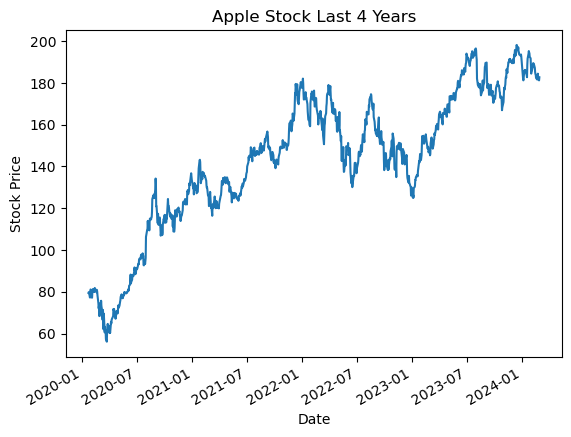

In [11]:
df2.plot(y='Close', kind='line', linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Apple Stock Last 4 Years')

# Show the plot
plt.show()

In [12]:
scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df2).reshape(-1,1))
df2.shape

(1032, 1)

In [13]:
train_data=df2[0:1030]
valid_data=df2[1030:,]

train_size = int(len(df2)*0.80)
test_size = len(df2) - train_size
train_data, test_data = df2[:train_size], df2[train_size:]

In [14]:
def create_dataset(data, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(data)-time_step-1):
                   a = data[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(data[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [15]:
time_step = 100
X_train, Y_train =  create_dataset(train_data, time_step)
X_test, Y_test =  create_dataset(test_data, time_step)

In [16]:
# checking values
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(Y_test.shape)

(724, 100)
[[0.16429316 0.16698649 0.16536695 ... 0.22615171 0.19633143 0.20143643]
 [0.16698649 0.16536695 0.14889013 ... 0.19633143 0.20143643 0.20881228]
 [0.16536695 0.14889013 0.16427554 ... 0.20143643 0.20881228 0.22481383]
 ...
 [0.64736739 0.64933897 0.64581828 ... 0.76700057 0.76918339 0.75819884]
 [0.64933897 0.64581828 0.6375095  ... 0.76918339 0.75819884 0.75812836]
 [0.64581828 0.6375095  0.61131553 ... 0.75819884 0.75812836 0.79087087]]
(106, 100)
(106,)


In [17]:
stock_model = Sequential()
stock_model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
stock_model.add(LSTM(50,return_sequences = True))
stock_model.add(LSTM(50))
stock_model.add(Dense(1))
stock_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [18]:
stock_model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 20,batch_size = 32,verbose = 1)

Epoch 1/20
23/23 [==============================] - 15s 253ms/step - loss: 0.0458 - val_loss: 0.0022
Epoch 2/20
23/23 [==============================] - 4s 170ms/step - loss: 0.0053 - val_loss: 0.0094
Epoch 3/20
23/23 [==============================] - 4s 176ms/step - loss: 0.0036 - val_loss: 0.0120
Epoch 4/20
23/23 [==============================] - 4s 190ms/step - loss: 0.0030 - val_loss: 0.0073
Epoch 5/20
23/23 [==============================] - 4s 163ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 6/20
23/23 [==============================] - 4s 161ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/20
23/23 [==============================] - 4s 167ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 8/20
23/23 [==============================] - 4s 162ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 9/20
23/23 [==============================] - 4s 167ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/20
23/23 [==============================] - 4s 160ms/step - loss: 0.0025 - val_loss: 0.002

In [20]:
train_predict = stock_model.predict(X_train)
test_predict = stock_model.predict(X_test)

4/4 [==============================] - 0s 48ms/step


In [21]:
# transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [22]:
model_predictions = stock_model.predict(X_train)
true_labels = Y_train

23/23 [==============================] - 1s 55ms/step


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(true_labels, model_predictions)
print("Mean Absolute Error (MAE):", mae)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(true_labels, model_predictions)
print("Mean Squared Error (MSE):", mse)

# Compute R^2 Score
r2 = r2_score(true_labels, model_predictions)
print("R^2 Score:", r2)

Mean Absolute Error (MAE): 0.03098848170784855
Mean Squared Error (MSE): 0.0015099952264857014
R^2 Score: 0.9264258756277922


In [24]:
look_back = 100

trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(df2)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df2) - 1,:] = test_predict

In [25]:
trainPredictPlot = pd.DataFrame(trainPredictPlot)
trainPredictPlot[800:]

,0
800,155.705856
801,156.616333
802,157.378128
803,158.047348
804,158.679733
...,...
1027,NaN
1028,NaN
1029,NaN
1030,NaN


In [26]:
df2 = scaler.inverse_transform(df2)

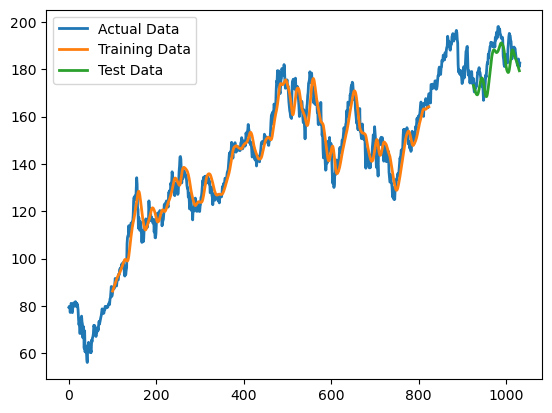

In [27]:
plt.plot(df2, label="Actual Data", linewidth=2)
plt.plot(trainPredictPlot, label="Training Data", linewidth=2)
plt.plot(testPredictPlot, label="Test Data", linewidth=2)

plt.legend()
plt.show()

In [28]:
# Number of future days to predict
future_days = 1
future_predictions = []
last_sequence = X_test[-1].reshape(1, -1)

for i in range(future_days):
    # Predict the next day's value with last sequence
    next_prediction = stock_model.predict(last_sequence)
    # Inverse transform to get the actual predicted value
    next_prediction = scaler.inverse_transform(next_prediction)
    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)
    # Update last_sequence for the next prediction
    last_sequence = next_prediction.reshape(1, -1)

1/1 [==============================] - 0s 96ms/step


In [29]:
future_predictions

[array([[179.39821]], dtype=float32)]

In [30]:
df2 = pd.DataFrame(df2)

In [31]:
df2[['Close']] = df2

In [32]:
df2 = df2[['Close']]
df2

,Close
0,79.425003
1,79.807503
2,79.577499
3,77.237503
4,79.422501
...,...
1027,182.320007
1028,184.369995
1029,182.520004
1030,181.160004


In [33]:
model_data=df2[:1031]
predict_data=df2[1031:]
predict_data['Predictions']=next_prediction
print(predict_data)
print(f'Predicted Closing Price for February 28th, 2024:{next_prediction}')

           Close  Predictions
1031  182.630005   179.398209
Predicted Closing Price for February 28th, 2024:[[179.39821]]


/var/folders/ls/v3r2prdx28d3rkgp7xr77q0w0000gn/T/ipykernel_23237/1037208927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predictions']=next_prediction


In [54]:
# Create traces
trace1 = go.Scatter(x=df2.index, y=df2['Close'], mode='lines', name='Actual Data', line=dict(width=2))

# Plot layout
layout = go.Layout(
    title='Actual Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure
fig = go.Figure(data=[trace1], layout=layout)

# Show plot
fig.show()

In [46]:
print("trainPredictPlot values:", trainPredictPlot)
print("testPredictPlot values:", testPredictPlot)

trainPredictPlot values:        0
0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
...   ..
1027 NaN
1028 NaN
1029 NaN
1030 NaN
1031 NaN

[1032 rows x 1 columns]
testPredictPlot values: [[         nan]
 [         nan]
 [         nan]
 ...
 [179.96005249]
 [179.39823914]
 [         nan]]


In [56]:
trace_test = go.Scatter(x=df2.index[len(df2) - len(testPredictPlot):], y=testPredictPlot.flatten(), mode='lines', name='Test Data', line=dict(width=2))

# Plot layout for test data
layout_test = go.Layout(
    title='Test Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for test data
fig_test = go.Figure(data=[trace_test], layout=layout_test)

# Show plot for test data
fig_test.show()

In [59]:
# Create trace for training data
trace_train = go.Scatter(x=df2.index[:len(trainPredictPlot)], y=trainPredictPlot.values.flatten(), mode='lines', name='Training Data', line=dict(width=2))

# Plot layout for training data
layout_train = go.Layout(
    title='Training Data',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for training data
fig_train = go.Figure(data=[trace_train], layout=layout_train)

# Show plot for training data
fig_train.show()

In [60]:
# Create traces for all three datasets
trace_actual = go.Scatter(x=df2.index, y=df2['Close'], mode='lines', name='Actual Data', line=dict(width=2))
trace_test = go.Scatter(x=df2.index[len(df2) - len(testPredictPlot):], y=testPredictPlot.flatten(), mode='lines', name='Test Data', line=dict(width=2))
trace_train = go.Scatter(x=df2.index[:len(trainPredictPlot)], y=trainPredictPlot.values.flatten(), mode='lines', name='Training Data', line=dict(width=2))

# Plot layout for all datasets
layout_all = go.Layout(
    title='Actual Data vs Training vs Test',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Closing Price'),
    legend=dict(x=0, y=1, traceorder="normal")
)

# Create figure for all datasets
fig_all = go.Figure(data=[trace_actual, trace_test, trace_train], layout=layout_all)

# Show plot for all datasets
fig_all.show()